## Problem with outliers

As we see in the following example, extreme outlier values in the data can distort the linear regression, such that the estimated slope is totally wrong.

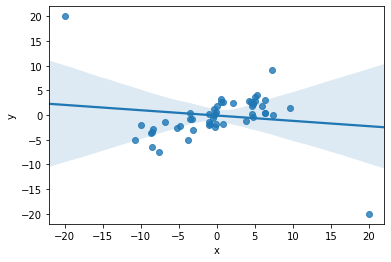

In [44]:
x = 5* scipy.stats.norm.rvs(size=50)
y = 0.5*x + 2*scipy.stats.norm.rvs(size=50)

#adding 2 points: (-20,20) and (20-20) for corresponding x- and y-values:
x = np.append(x, [-20,20])
y = np.append(y, [20,-20])

df = pd.DataFrame({'x' : x, 'y': y})

sns.regplot(x='x', y='y', data=df)

Evidently, the estimated slope is totally wrong if there are certain outliers in the data set (note: not all outliers distort). `RANSAC` is an algorithm to identify these far-off outliers and eliminate them from the data set. The cleaned data set is then ready for a sufficient linear regression.

## RANSAC manual

**RAN**dom **SA**mple **C**onsensus Algorithm enables robust regression.

1. Given dataset `df` consisting of many inliers and a few outliers.
2. We keep randomly selecting a small subset `sample` of `df` (in a loop). *Small enough such that its unlikely that the outliers are in it and large enough such that linear regression is possible. We don't know if outliers are in it, but we hope that most are inliers.*
3. We fit a linear regression model to `sample`.
4. We loop through all data points of `df` and for each point: if the residual is smaller than a given `residual_threshold`, then we add this point to a `consensus` set, *thus we assume that this point is an inlier. `consensus` holds all inlier points of `df`.*
5. (Ignore for first loop step of 2: if `consensus` set has more data points that `inliers`, then:) We fit a linear regression model to the `consensus` set. *This model will be robust, because it is not distorted by outliers.*
6. (Ignore for first loop step of 2: if the models `MSE` is smaller than the `MSE` of `best_model`, then:) set this to be new `best_model`. We set `inliers` to be the `consensus` set. *So if this new model is really better, we keep it to be the new best model and we confirm the `consensus` points to officially be `inliers`.*
7. Go back to 2. until a given number of trials is achieved.
8. return `inliers` and `best_model`.  



In [1]:
import numpy as np
import pandas as pd
import scipy
import seaborn as sns

from sklearn import linear_model
from sklearn import metrics

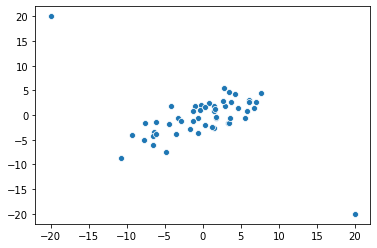

In [2]:
x = 5* scipy.stats.norm.rvs(size=50)
y = 0.5*x + 2*scipy.stats.norm.rvs(size=50)

#adding 2 points: (-20,20) and (20-20) for corresponding x- and y-values:
x = np.append(x, [-20,20])
y = np.append(y, [20,-20])

df = pd.DataFrame({'x' : x, 'y': y})

sns.scatterplot(x,y)

In [16]:
def RANSAC(df, number_samples, trials, residual_threshold):

    #will be LinearRegression Object:
    best_model = None

    #Set of certain inliers:
    inliers = pd.DataFrame()

    for i in range(trials):

        #randomly select a small number of points:
        sample = df.sample(number_samples)

        #Fit sample to linear regression model:
        model = linear_model.LinearRegression()
        model.fit(sample[['x']], sample[['y']])

        #Set of temperal inliers:
        consensus = pd.DataFrame()

        #Loop through rows of data:
        for index, row in df.iterrows():
            #if residual is "small" enough...
            if( (model.intercept_[0] + model.coef_[0][0]*row['x'] - row['y'])**2 <= residual_threshold ):
                #...then we add this point to consensus
                consensus = consensus.append(df.iloc[index])

        #If inliers is not the majority of the inliers of the data set yet...
        if( best_model==None or len(consensus)>len(inliers) ):
            #...then we fit a new model to consensus...
            model = linear_model.LinearRegression()
            model.fit(consensus[['x']],consensus[['y']])
            #...and measure the accuracy..
            mse = metrics.mean_squared_error(consensus[['y']], model.predict(consensus[['x']]))

            #..and if this new model is better than our current best model...
            if( best_model==None or mse<metrics.mean_squared_error(consensus[['y']], best_model.predict(consensus[['x']])) ):
                #...then we set this model to be our new best model...
                best_model = model
                #...and we put all the consensus points into the global inlier set for good!
                inliers = consensus.copy()

                print('Updated slope to {0}'.format(best_model.coef_[0][0]))

    #At the end, we return the best linear model built up with pure inliers and no outliers; and the set of inliers:
    return inliers, best_model

In [20]:
inliers, best_model = RANSAC(df, number_samples=10, trials=100, residual_threshold=5)

Updated slope to 0.6502545763162842
Updated slope to 0.4154951120267761
Updated slope to 0.594554173715121
Updated slope to 0.3706541173050825


`df.isin(inliers)` checks if points of `inliers` are in `df`; returns a 2-column (x and y) dataframe with True, whether the datapoint (x,y) in `df` is an inlier. 

`~df.isin(inliers)` negates the value with True, whether the datapoint (x,y) in `df` is an outlier.

`~df.isin(inliers).all(axis=1)` aggregates the 2-columns with identical values to 1-column.

`outliers = df[~df.isin(inliers).all(axis=1)]` only takes the values of `df` with True value and stores them in `outliers`.

In [33]:
outliers = df[~df.isin(inliers).all(axis=1)]

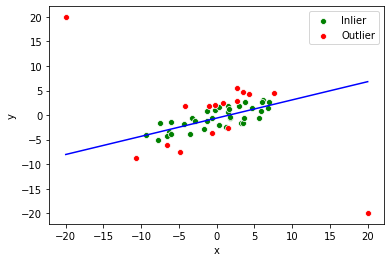

In [36]:
#Plot inliers:
sns.scatterplot(x='x', y='y', data=inliers, color='green', label='Inlier')
#Plot outliers:
sns.scatterplot(x='x', y='y', data=outliers, color='red', label='Outlier')
#Plot regression line:
#reshaping is needed to have a 1-dim array:
sns.lineplot(df['x'].values, best_model.predict(df[['x']]).reshape(1,-1)[0], color='blue')